<h1> Procesamiento de las imágenes </h1>



Para el procesamiento de las imagenes, el primer paso es leerlas de la carpeta correspondiente, la cual se encuentra en la carpeta srcImg, por lo tanto:

# Librerias en general

Filtros para detectar vidrio
2.- transformada de hough para recortar el centro para lineas verticales
Filtro de gabor 
1.- hacer pruebas con imagenes recortadas a solo la pecera para ver su procesamiento e histogramas 
busqueda de contornos


In [106]:
"""
Biblioteca:
-   cv2             Manejo de imágenes
-   numpy           Manejo de arreglos de pixeles
(Prueba)-   cv2_imshow      Parche para mostrar imágenes en Colab

-   time            Biblioteca para debuggear
-   matplotlib      Manejo de las impresiones de imagenes
"""
%matplotlib inline

import os
import cv2
import numpy as np
import random
#from google.colab.patches import cv2_imshow

import time 
from matplotlib import pyplot as plt

# Dirección principal
dir = "c:/Users/jose_/Desktop/Tesis/Programa"
# Direccion de guardado de imágenes
outDir = os.getcwd()+"\Imagenes"
# Direccion de carga de videos
inDir = os.getcwd()+"\Videos"
#Dirección de guardado de cada canal
outChan = os.getcwd()+"\Canales"
#Dirección de guardado de los histogramas de cada canal
outHist = os.getcwd()+"\Histogramas"



# Obteniendo las imagenes
global imgs 
global file_names


# <h1> Métodos para guardar imagenes en una carpeta determinada </h1>

In [107]:
def saveImages(dir, text, lImgs):
    os.chdir(dir)
    count = 1
    for img in lImgs:
        cv2.imwrite("",img)
        cv2.imwrite(text+ str(count ) + ".jpg", img)

## Creamos un método para obtener las imágenes de una carpeta determinada


In [108]:
"""
    Método getImages, el cual nos permite obtener todas las imagenes guardadas en una determinada carpeta
    Entrada: No recibe nada
    Salida: Una lista de imagenes
"""
def getImages(dir):

    images = list()                                 # Creamos una lista en donde guardaremos temporalmente las imagenes con el fin de no duplicar imagenes
    names = list()
    file_names = os.listdir(dir)                 # Obtenemos el nombre de todos los archivos que se encuentran en la carpeta outDir (Es donde se guardan las imagenes)

    print(file_names)
    # file_names = sorted(file_names, key=lambda s: int(s.split('.')[0][5:])) # Ordenamos los archivos mediante el numero de la imagen

    # Creamos un bucle para cada elemento dentro de la carpeta    
    for file in file_names:
        print(file)
        image_path = dir + "/" + file            # Creamos la variable de la direccion de cada imagen
        image = cv2.imread(image_path)              # Leemos la imagen
        if image is None:                           # Si por alguna cuestion no se puede leer la imagen se descarta
            continue
            
        images.append(image)                        # Agregamos la imagen leida a la lista de imagenes
        names.append(file)

    return images, names                            # Retornamos la lista de imagenes

# Asignamos la lista de imagenes que regresa el metodo getImages a la lista global imgs
imgs, file_names = getImages(outDir)

['image0000.jpg', 'image0001.jpg', 'image0002.jpg', 'image0003.jpg', 'image0004.jpg', 'image0005.jpg', 'image0006.jpg', 'image0007.jpg', 'image0008.jpg', 'image0009.jpg', 'image0010.jpg', 'image0011.jpg', 'image0012.jpg', 'image0013.jpg', 'image0014.jpg', 'image0015.jpg', 'image0016.jpg', 'image0017.jpg', 'image0018.jpg', 'image0019.jpg', 'image0020.jpg', 'image0021.jpg', 'image0022.jpg', 'image0023.jpg', 'image0024.jpg', 'image0025.jpg', 'image0026.jpg', 'image0027.jpg', 'image0028.jpg', 'image0029.jpg', 'image0030.jpg', 'image0031.jpg', 'image0032.jpg', 'image0033.jpg', 'image0034.jpg', 'image0035.jpg', 'image0036.jpg', 'image0037.jpg', 'image0038.jpg', 'image0039.jpg', 'image0040.jpg', 'image0041.jpg', 'image0042.jpg', 'image0043.jpg', 'image0044.jpg', 'image0045.jpg', 'image0046.jpg', 'image0047.jpg', 'image0048.jpg', 'image0049.jpg', 'image0050.jpg', 'image0051.jpg', 'image0052.jpg', 'image0053.jpg', 'image0054.jpg', 'image0055.jpg', 'image0056.jpg', 'image0057.jpg', 'image0058.jp

- Nos aseguramos que la lista de imagenes sea del mismo tamaño que la lista de archivos que se encuentran en la carpeta Imagenes

In [109]:
print(len(imgs))

print(len(file_names))

124
124


## Procesamiento de las imágenes

Para el procesamiento de las imágenes se probaran distintos métodos.

Parámetros:
- Entrada: Una lista de fotos a color.
- Salida: Una lista de imágenes a escala de grises y una lista de sus respectivos histogramas
__________________________________________________________

Primero creamos un método para imprimir dos imágenes en cuestión, cada una con su leyenda impresa en la parte superior de cada imagen

- txtimg: Leyenda a imprimir en imágen 1
- img1: Imágen 1 a imprimir
- txtimg2: Leyenda a imprimir en imágen 2
- img2: Imágen 2 a imprimir

In [85]:
"""
  Método para imprimir dos imagenes en la pantalla (una a un lado de la otra)
  con el fin de debuguear y observar la imagen original y la modificada
"""
def drawImages(txtimg1, img1, txtimg2, img2):
  plt.subplot(121)
  plt.imshow(img1,cmap = 'gray')

  plt.title(txtimg1)
  plt.xticks([]), plt.yticks([])

  plt.subplot(122)
  plt.imshow(img2,cmap = 'gray')

  plt.title(txtimg2)
  plt.xticks([]), plt.yticks([])

  plt.show()

### Ahora procedemos a la búsqueda de los histogramas en cada canal

Una vez obtenido el histograma, procedemos a guardarlo en la carpeta Histogramas

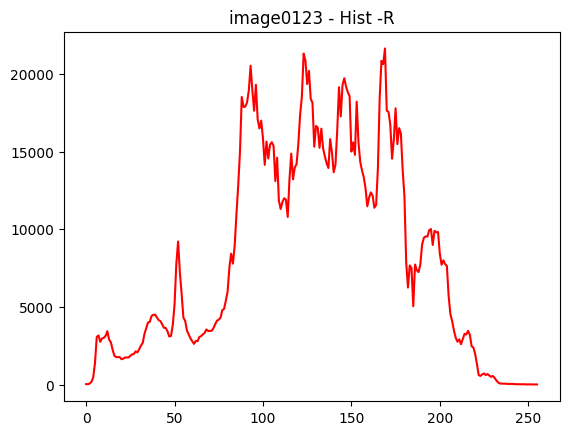

In [44]:
os.chdir(outHist)
for j, image in enumerate(imgs):
    # define colors to plot the histograms
    colors = ('b','g','r')
    hist = list()
    fname = os.path.splitext(file_names[j])[0]

    # compute and plot the image histograms
    for i,color in enumerate(colors):
        hist.append(cv2.calcHist([image],[i],None,[256],[0,256]))

    for i,h in enumerate(hist):
        plt.clf()
        plt.plot(h, colors[i])
        plt.title(fname + " - " + "Hist -" + colors[i].upper())
        plt.savefig(fname + " - " + colors[i].upper() + '.jpg')

os.chdir(dir)

- Corroboramos que nos encontremos en la carpeta raiz del proyecto 

In [110]:
print(os.listdir())
print(os.getcwd())

['Histogramas', 'Imagenes', 'ImagesProcessing.ipynb', 'Notas.md', 'VideoProcessing.ipynb', 'Videos']
c:\Users\jose_\Desktop\Tesis\Programa


### Procedemos a obtener el histograma en escala de grises

Una vez obtenido el histograma, procedemos a guardarlo en la carpeta Histogramas

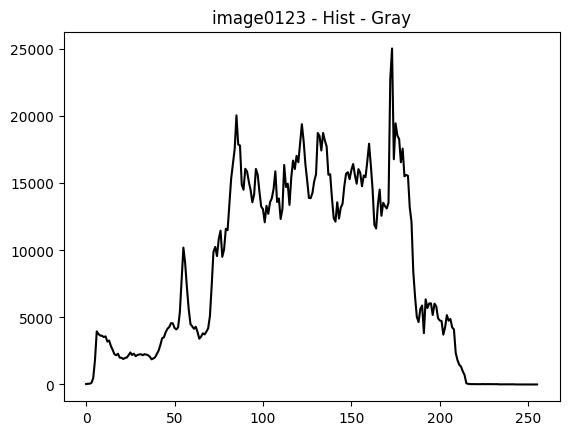

In [46]:
os.chdir(outHist)
for j, image in enumerate(imgs):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    fname = os.path.splitext(file_names[j])[0]

    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    
    plt.clf()
    plt.plot(hist, 'k')
    plt.title(fname + " - " + "Hist - Gray")
    plt.savefig(fname + " - Gray.jpg")
os.chdir(dir)

# <h1> Aqui iniciamos a separar las imagenes en cada canal B, G, R y Escala de Grises guardandolos en una lista distinta cada uno </h1>

In [111]:
b = list()
g = list()
r = list()
gray = list()

for img in imgs:

    cv2.imshow("Original ",img)

    bI, gI, rI = cv2.split(img)
    grayI = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    b.append(bI)
    g.append(gI)
    r.append(rI) 
    gray.append(grayI)

    cv2.imshow("B-Image", bI)
    
    cv2.imshow("G-Image", gI)
    cv2.imshow("R-Image", rI)
    
    # cv2.imshow("Gray-Image", gray)
    cv2.waitKey(100)
cv2.destroyAllWindows()

# Aqui inician las pruebas con los valores de umbral de cada canal

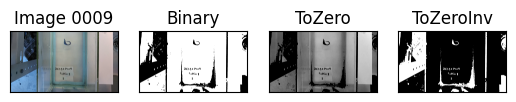

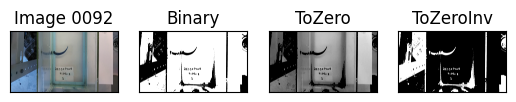

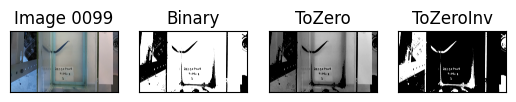

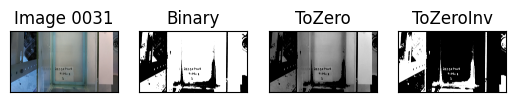

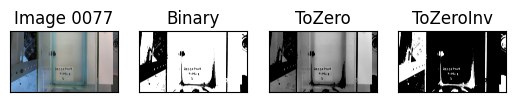

In [130]:
for i in range(0, 5, 1):
    n = random.randint(0, len(imgs)-1)

    img = imgs[n]
    # cv2.imshow("Image",img)
    B = img[:,:,0] # B
    G = img[:,:,1] # G
    R = img[:,:,2] # R

    # Threshold Blue Image
    # _, tresh = cv2.threshold(np.hstack([B]), 80, 255, cv2.THRESH_BINARY )
    # tresh = cv2.resize(tresh,(512,512))
    # cv2.imshow('Thresh B', treshB)

    # # Threshold Green Image
    # _, treshG = cv2.threshold(np.hstack([G]), 185, 255, cv2.THRESH_BINARY)
    # treshG = cv2.resize(treshG,(512,512))
    # cv2.imshow('Thresh G', treshG)

    # Threshold Red Image
    # _, treshR = cv2.threshold(np.hstack([R]), 180, 255, cv2.THRESH_BINARY)
    # treshR = cv2.resize(treshR,(512,512))
    # cv2.imshow('Thresh R', treshR)

    tsh = 80

    _, threshBinary = cv2.threshold(B, tsh, 255, cv2.THRESH_BINARY)
    _, threshToZero = cv2.threshold(B, tsh, 255, cv2.THRESH_TOZERO )
    _, threshToZeroInvImg = cv2.threshold(B, tsh, 255, cv2.THRESH_BINARY_INV)

    plt.subplot(341),plt.imshow(img, cmap = 'gray')
    plt.title('Image '+ file_names[n].split(".")[0][5:]), plt.xticks([]), plt.yticks([])
    plt.subplot(342),plt.imshow(threshBinary, cmap = 'gray')
    plt.title('Binary'), plt.xticks([]), plt.yticks([])
    plt.subplot(343),plt.imshow(threshToZero, cmap = 'gray')
    plt.title('ToZero'), plt.xticks([]), plt.yticks([])
    plt.subplot(344),plt.imshow(threshToZeroInvImg, cmap = 'gray')
    plt.title('ToZeroInv'), plt.xticks([]), plt.yticks([])
    plt.show()

    # cv2.waitKey(1000)
# cv2.destroyAllWindows()

# En esta segunda prueba creamos un desenfoque con el fin de obtener mejores resultados

- Primero hacemos un desenfoque con la función GaussianBlur
- Se ejecuta una busqueda de bordes con los valores entre 75 y 80


In [99]:
for img in imgs:
    img = cv2.resize(img, (512,512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    dst = cv2.GaussianBlur(img,(11,11),cv2.BORDER_DEFAULT)

    tresh = cv2.Canny(img, 75, 80)

    # _, treshR = cv2.threshold(np.hstack([dst]), 80, 255, cv2.THRESH_BINARY)
    # treshR = cv2.resize(treshR,(512,512))
    # cv2.imshow('Thresh R', treshR)

    cv2.imshow("Image", np.hstack((img, dst, tresh)))
    cv2.waitKey(400)
cv2.destroyAllWindows()

# Recorremos todas las imagenes implementando una busqueda de bordes con la función Canny con los mismos valores de umbral usados anteriormente

In [100]:
i = 0
for img in imgs:
    img = cv2.resize(img, (512,512))
    # print(i)
    cv2.imshow("RGB-Image", img)
    # b,g,r = cv2.split(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    b[i] = cv2.Canny(b[i], 100, 110) #  60-70, 70-90, 100-110
    g[i] = cv2.Canny(g[i], 140, 150) # 100-110, 130-140, 140-150, 170-185
    r[i] = cv2.Canny(r[i], 130, 150) # 50-70, 90-110, 130-150, 170-180

    # cv2.imshow("BGR-Image", img)
    cv2.imshow("B-Image", b[i])
    
    cv2.imshow("G-Image", g[i])
    cv2.imshow("R-Image", r[i])
    cv2.imshow("Gray-Image", gray)
    cv2.waitKey(100)
    i = i+1
cv2.destroyAllWindows()

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = imgs[10]
img = cv2.resize(img, (512,512))
# GRISES
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = np.float64(img)

cv2.imshow("Imagen Original", img)
dft = cv2.dft(img)

# TRANSFORMADA DE FOURIER EN 2D
frr = np.fft.fft2(dft)
frr = np.fft.fftshift(frr)

# CALCULAR LA MAGNITUD DEL ARREGLO
frr_abs = np.abs(frr)

# ESPECTRO DE FRECUENCIA EN ESCALA LOGARITMICA
frr_log = 20*np.log10(frr_abs)

# MOSTRAMOS LA IMAGEN
img_frr = np.uint8(255*frr_log/np.max(frr_log))
cv2.imshow("Espectro de Fourier Logaritmica",img_frr)


cv2.waitKey(0)
cv2.destroyAllWindows()


NameError: name 'imgs' is not defined

# <h1> Iniciando la prueba de los filtros con la Transformada de Fourier </h1>

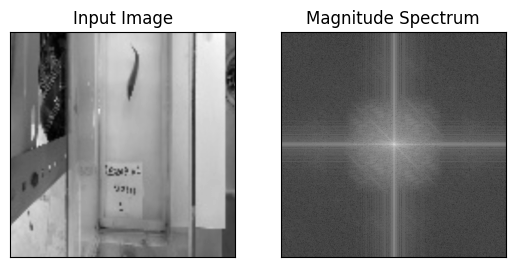

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = imgs[1]
img = cv2.resize(img, (512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

f = np.fft.fft2(img)
# print(f)
fshift = np.fft.fftshift(f)
# print(fshift)
magnitude_spectrum = 20*np.log(np.abs(fshift))
# print(magnitude_spectrum)

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

(512, 512)


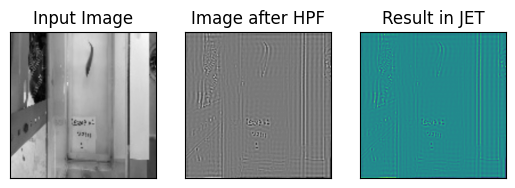

In [ ]:
print(img.shape)
rows, cols = img.shape
crow,ccol = rows//2 , cols//2
fshift[crow-30:crow+31, ccol-30:ccol+31] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.real(img_back)
plt.subplot(131),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(img_back)
plt.title('Result in JET'), plt.xticks([]), plt.yticks([])
plt.show()

-------------------------------------------------------------------------------

---------------------------------------------------------------------------------------

# <center> <h1> Aqui inician las pruebas con las imagenes recortadas </h1> </center>

--------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------

In [48]:
"""
Biblioteca:
-   cv2             Manejo de imágenes
-   numpy           Manejo de arreglos de pixeles
(Prueba)-   cv2_imshow      Parche para mostrar imágenes en Colab

-   time            Biblioteca para debuggear
-   matplotlib      Manejo de las impresiones de imagenes
"""
%matplotlib inline

import os
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow

import time 
from matplotlib import pyplot as plt

# Dirección principal
dir = "c:/Users/jose_/Desktop/Tesis/Programa"
# Direccion de guardado de imágenes
outDir = os.getcwd()+"\Imagenes"
# Direccion de carga de videos
inDir = os.getcwd()+"\Videos"
#Dirección de guardado de cada canal
outChan = os.getcwd()+"\Canales"
#Dirección de guardado de los histogramas de cada canal
outHist = os.getcwd()+"\Histogramas"



# Obteniendo las imagenes
global imgs 
global file_names

In [101]:
"""
    Método getImages, el cual nos permite obtener todas las imagenes guardadas en una determinada carpeta
    Entrada: No recibe nada
    Salida: Una lista de imagenes
"""
def getImages(dir):
    dir = dir + "/Prueba"
    print(dir)
    images = list()                                 # Creamos una lista en donde guardaremos temporalmente las imagenes con el fin de no duplicar imagenes
    names = list()
    file_names = os.listdir(dir)                 # Obtenemos el nombre de todos los archivos que se encuentran en la carpeta outDir (Es donde se guardan las imagenes)

    file_names = sorted(file_names, key=lambda s: int(s.split('.')[0][5:])) # Ordenamos los archivos mediante el numero de la imagen

    # Creamos un bucle para cada elemento dentro de la carpeta    
    for file in file_names:
        print(file)
        image_path = dir + "/" + file            # Creamos la variable de la direccion de cada imagen
        image = cv2.imread(image_path)              # Leemos la imagen
        if image is None:                           # Si por alguna cuestion no se puede leer la imagen se descarta
            continue
            
        images.append(image)                        # Agregamos la imagen leida a la lista de imagenes
        names.append(file)

    return images, names                            # Retornamos la lista de imagenes

# Asignamos la lista de imagenes que regresa el metodo getImages a la lista global imgs
imgs, file_names = getImages(outDir)

c:\Users\jose_\Desktop\Tesis\Programa\Imagenes/Prueba
image0000.jpg
image0010.jpg
image0021.jpg
image0039.jpg


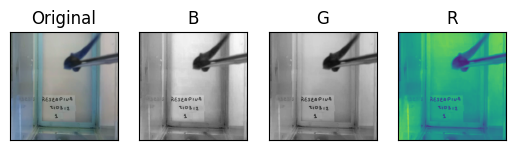

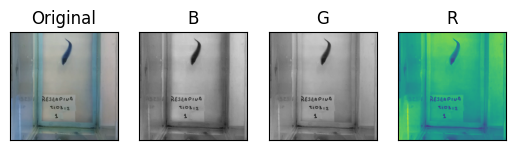

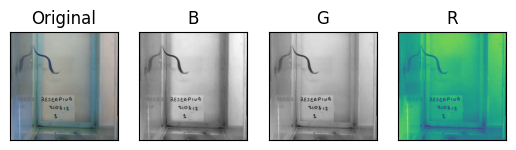

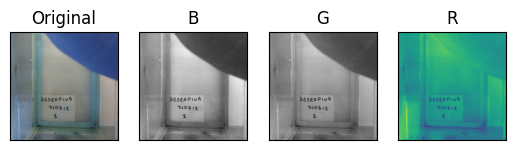

In [102]:
B = list()
G = list()
R = list()
for img in imgs:
    b, g, r = cv2.split(img)
    img = cv2.resize(img, (1080,1080))
    b = cv2.resize(b, (1080, 1080))
    g = cv2.resize(g, (1080, 1080))
    r = cv2.resize(r, (1080, 1080))

    B.append(b)
    G.append(g)
    R.append(R)

    plt.subplot(141),plt.imshow(img, cmap = 'gray')
    plt.title('Original'), plt.xticks([]), plt.yticks([])
    plt.subplot(142),plt.imshow(b, cmap = 'gray')
    plt.title('B'), plt.xticks([]), plt.yticks([])
    plt.subplot(143),plt.imshow(g, cmap = 'gray')
    plt.title('G'), plt.xticks([]), plt.yticks([])
    plt.subplot(144),plt.imshow(r)
    plt.title('R'), plt.xticks([]), plt.yticks([])
    plt.show()

In [103]:
print(len(B))
print(len(G))
print(len(R))

4
4
4


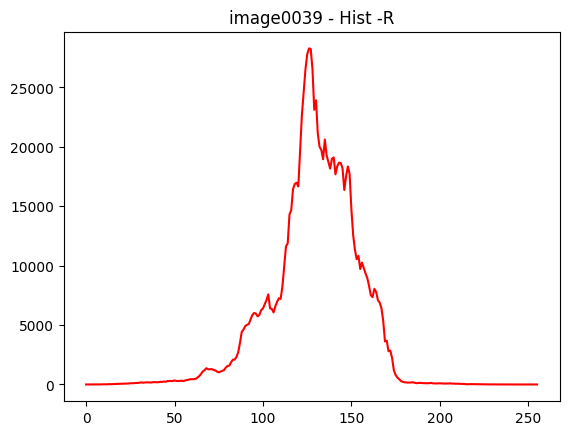

In [45]:
os.mkdir(outHist+"/Prueba")
os.chdir(outHist+"/Prueba")
for j, image in enumerate(imgs):
    # define colors to plot the histograms
    colors = ('b','g','r')
    hist = list()
    fname = os.path.splitext(file_names[j])[0]

    # compute and plot the image histograms
    for i,color in enumerate(colors):
        hist.append(cv2.calcHist([image],[i],None,[256],[0,256]))

    for i,h in enumerate(hist):
        plt.clf()
        plt.plot(h, colors[i])
        plt.title(fname + " - " + "Hist -" + colors[i].upper())
        plt.savefig(fname + " - " + colors[i].upper() + '.jpg')

os.chdir(dir)

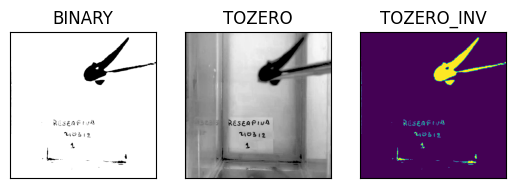

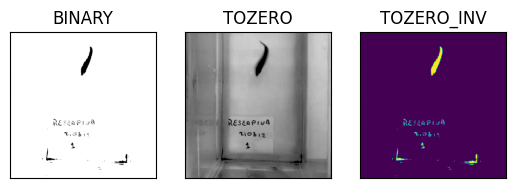

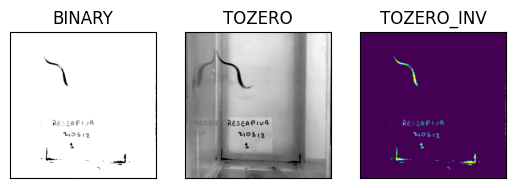

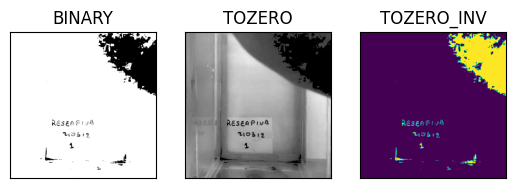

In [104]:
for i in range(0,4,1):
    # Threshold Blue Image
    #  60-70, 70-90, 100-110
    _, treshB = cv2.threshold(B[i], 50, 255, cv2.THRESH_BINARY )
    _, treshT = cv2.threshold(B[i], 50, 255, cv2.THRESH_TOZERO )
    # cv2.imshow('Thresh B', treshB)

    _, threshB = cv2.threshold(treshB, 70, 255, cv2.THRESH_BINARY_INV)
    # cv2.imshow("THRESH B INV", threshB)

    plt.subplot(231),plt.imshow(treshB, cmap = 'gray')
    plt.title('BINARY'), plt.xticks([]), plt.yticks([])
    plt.subplot(232),plt.imshow(treshT, cmap = 'gray')
    plt.title('TOZERO'), plt.xticks([]), plt.yticks([])
    plt.subplot(233),plt.imshow(threshB)
    plt.title('TOZERO_INV'), plt.xticks([]), plt.yticks([])
    plt.show()
    # cv2.imshow("Threshold", np.hstack([treshB, threshB]))

    # # Threshold Green Image
    # 100-110, 130-140, 140-150, 170-185
    # _, treshG = cv2.threshold(np.hstack([G]), 185, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # treshG = cv2.resize(treshG,(512,512))
    # cv2.imshow('Thresh G', treshG)

    # Threshold Red Image
    # 50-70, 90-110, 130-150, 170-180
    # _, treshR = cv2.threshold(np.hstack([R]), 180, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # treshR = cv2.resize(treshR,(512,512))
    # cv2.imshow('Thresh R', treshR)


# cv2.waitKey(0)
# cv2.destroyAllWindows()

### Utilizando el filtro Gausiano

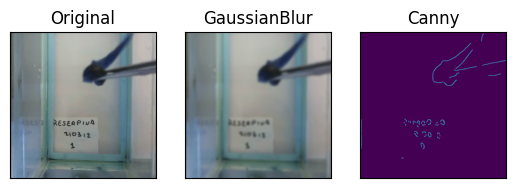

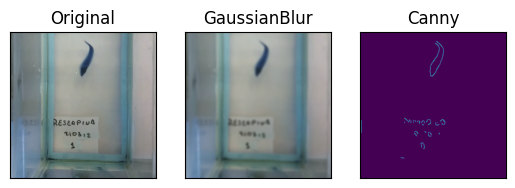

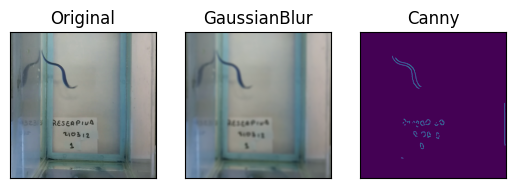

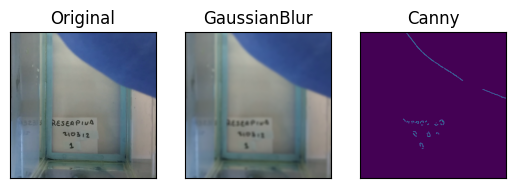

In [105]:
for img in imgs:
    img = cv2.resize(img, (512,512))
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    dst = cv2.GaussianBlur(img,(11,11),cv2.BORDER_DEFAULT)

    canny = cv2.Canny(dst, 75, 80)

    # _, treshR = cv2.threshold(np.hstack([dst]), 80, 255, cv2.THRESH_BINARY)
    # treshR = cv2.resize(treshR,(512,512))
    # cv2.imshow('Thresh R', treshR)
    cv2.imshow("Canny ", canny)

    plt.subplot(231),plt.imshow(img, cmap = 'gray')
    plt.title('Original'), plt.xticks([]), plt.yticks([])
    plt.subplot(232),plt.imshow(dst, cmap = 'gray')
    plt.title('GaussianBlur'), plt.xticks([]), plt.yticks([])
    plt.subplot(233),plt.imshow(canny)
    plt.title('Canny'), plt.xticks([]), plt.yticks([])
    plt.show()

    cv2.waitKey(1000)
cv2.destroyAllWindows()